In [1]:
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import wandb
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from wandb.keras import WandbCallback

from modules.evaluate.utils import plot_tsne_pds
from modules.training.ts_modeling import build_dataset, create_mlp, evaluate_model, \
    process_sep_events, build_univariate_dataset, generate_feature_names, sym_log1p, inverse_sym_log1p


from scipy.stats import pearsonr

In [2]:
# SEEDING
SEED = 42  # seed number 

# Set NumPy seed
np.random.seed(SEED)

# Set TensorFlow seed
tf.random.set_seed(SEED)

# Set random seed
random.seed(SEED)


In [3]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

(24217, 75, 1)
(24217,)
(18952, 75, 1)
(18952,)
(10357, 75, 1)
(10357,)
(5265, 75, 1)
(5265,)
X_train.shape: (24217, 75, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 75, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 75, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 75, 1)
y_val.shape: (5265,)
X_train[0]: [[0.83291813]
 [0.83244193]
 [0.83128651]
 [0.83031191]
 [0.82795357]
 [0.82972685]
 [0.82913708]
 [0.82226368]
 [0.81980303]
 [0.81911433]
 [0.81761693]
 [0.81884725]
 [0.81879556]
 [0.81841966]
 [0.81626247]
 [0.81702354]
 [0.81599169]
 [0.81549917]
 [0.81538844]
 [0.81522678]
 [0.81357089]
 [0.81149916]
 [0.81334833]
 [0.81401486]
 [0.81195032]
 [0.48465527]
 [0.4788582 ]
 [0.4788582 ]
 [0.47614084]
 [0.47311252]
 [0.47398247]
 [0.47180709]
 [0.45771414]
 [0.44302786]
 [0.44819982]
 [0.45129612]
 [0.4395381 ]
 [0.45298753]
 [0.44381562]
 [0.44287087]
 [0.44223638]
 [0.44144699]
 [0.44001532]
 [0.43358671]
 [0.43114536]
 [0.44413254]
 [0.43163419]
 [0.43260982]
 [0.4361

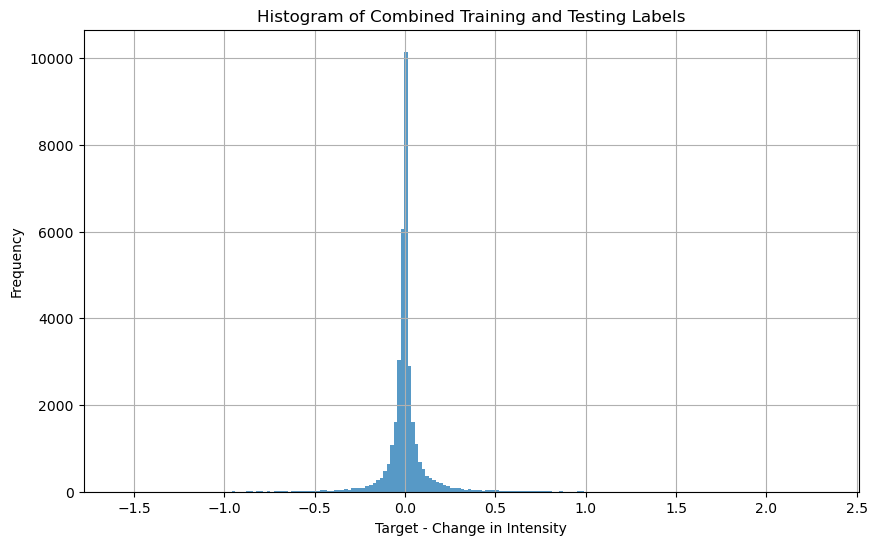

In [4]:
# Assuming y_train and y_test are your training and testing label arrays
# Combine the training and testing labels
combined_labels = np.concatenate([y_train, y_test])

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(combined_labels, bins=200, alpha=0.75)  # Adjust 'bins' as needed
plt.title('Histogram of Combined Training and Testing Labels')
plt.xlabel('Target - Change in Intensity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [5]:
# Find min and max y values
min_y_value = np.min(combined_labels)
max_y_value = np.max(combined_labels)
# Calculate frequencies of min and max y values
min_y_freq = np.count_nonzero(combined_labels == min_y_value)
max_y_freq = np.count_nonzero(combined_labels == max_y_value)
print(f'Min Y: {min_y_value}, Frequency: {min_y_freq}')
print(f'Max Y: {max_y_value}, Frequency: {max_y_freq}')

Min Y: -1.5838650212232528, Frequency: 1
Max Y: 2.3157651077870685, Frequency: 1


Highest frequency bin center: 0.005234256348452981, Frequency: 10150.0


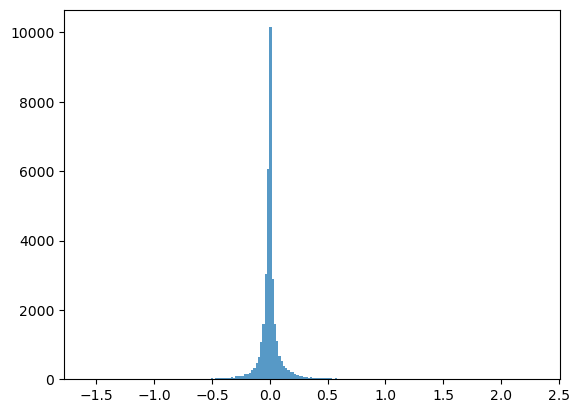

In [6]:
# Plot the histogram and get bin counts and edges
counts, bins, patches = plt.hist(combined_labels, bins=200, alpha=0.75)

# Find the bin with the highest frequency
highest_freq_index = np.argmax(counts)
highest_freq_bin_center = (bins[highest_freq_index] + bins[highest_freq_index + 1]) / 2
highest_freq = counts[highest_freq_index]
print(f'Highest frequency bin center: {highest_freq_bin_center}, Frequency: {highest_freq}')

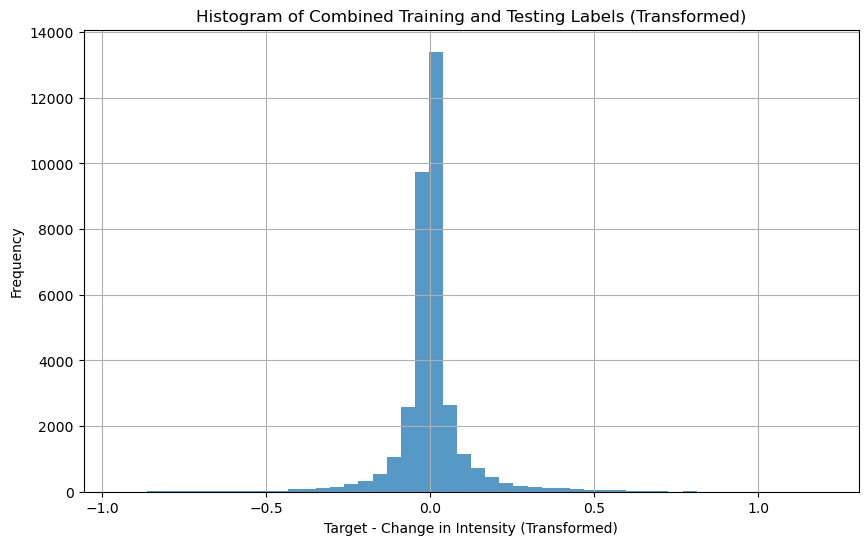

In [17]:
# Apply the desired function to the labels
transformed_labels = sym_log1p(combined_labels)  # Replace np.exp with your desired function

# Plot the histogram with transformed labels
plt.figure(figsize=(10, 6))
plt.hist(transformed_labels, bins=50, alpha=0.75)
plt.title('Histogram of Combined Training and Testing Labels (Transformed)')
plt.xlabel('Target - Change in Intensity (Transformed)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [8]:
# def apply_function(x, function):
#     """ Applies a function to each element of a NumPy array.
#   
#     Args:
#       x: A NumPy array.
#       function: A function that takes a single element of the array as input and returns the transformed value.
#   
#     Returns:
#       A new NumPy array with the transformed values.
#     """
#     return np.frompyfunc(lambda a: function(a), 1, 1)(x)
# 
# 
# # Apply the desired function to the labels
# transformed_labels = apply_function(combined_labels, np.log1p)  # Replace np.exp with your desired function
# 
# # Plot the histogram with transformed labels
# plt.figure(figsize=(10, 6))
# plt.hist(transformed_labels, bins=200, alpha=0.75)
# plt.title('Histogram of Combined Training and Testing Labels (Transformed)')
# plt.xlabel('Target - Change in Intensity (Transformed)')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()


In [9]:
# # Annotate min, max, and highest frequency y value
# plt.annotate(f'Min Y: {min_y_value:.2f}', xy=(min_y_value, 0), xytext=(min_y_value, 10),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate(f'Max Y: {max_y_value:.2f}', xy=(max_y_value, 0), xytext=(max_y_value, 10),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate(f'Highest Freq Y: {highest_freq_bin_center:.2f}\nFreq: {highest_freq}',
#              xy=(highest_freq_bin_center, highest_freq),
#              xytext=(highest_freq_bin_center, highest_freq + 0.05 * np.ptp(counts)),
#              arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center')
# 
# plt.show()

In [10]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
input_to_return = 'p_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

X_train.shape: (24217, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 1)
y_val.shape: (5265,)
X_train[0]: [0.50190577]
y_train[0]: 0.7607123667223692


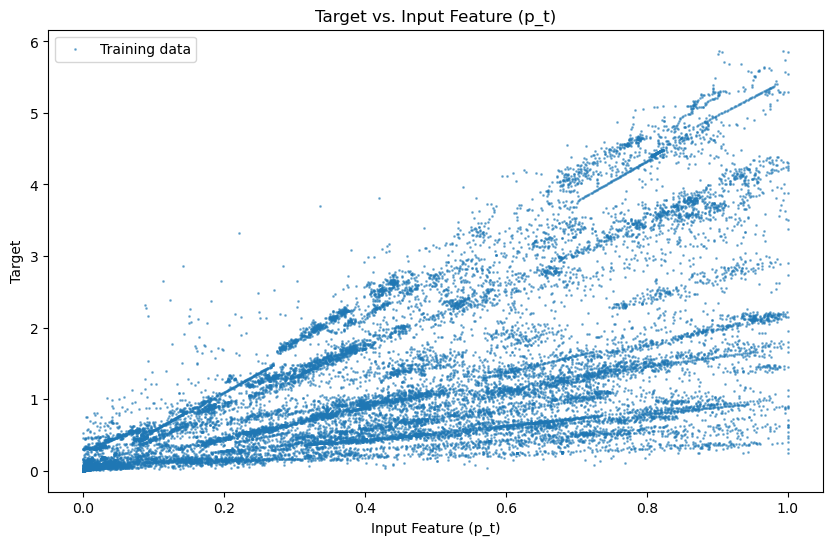

In [11]:
# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1)
plt.title('Target vs. Input Feature (p_t)')
plt.xlabel('Input Feature (p_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

X_train.shape: (24217, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 1)
y_val.shape: (5265,)
X_train[0]: [0.81195032]
y_train[0]: 0.7607123667223692


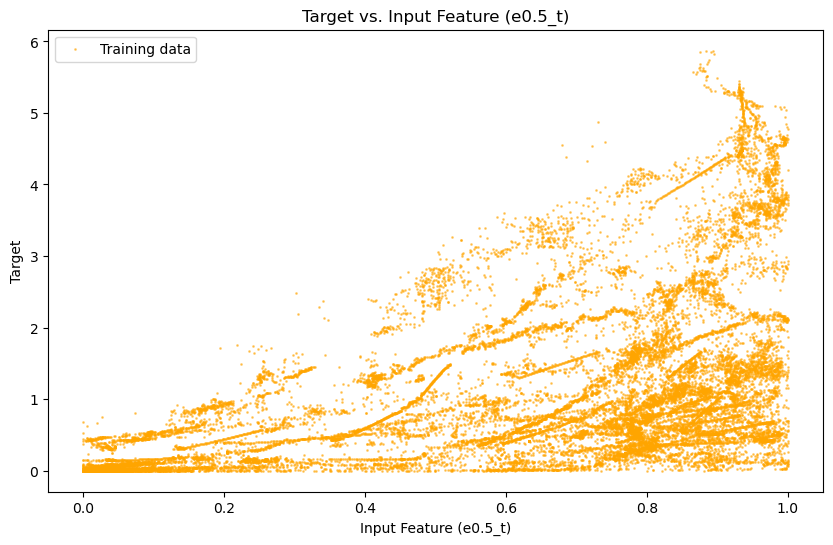

In [12]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
input_to_return = 'e0.5_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1, color='orange')
plt.title('Target vs. Input Feature (e0.5_t)')
plt.xlabel('Input Feature (e0.5_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

X_train.shape: (24217, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 1)
y_val.shape: (5265,)
X_train[0]: [0.42521301]
y_train[0]: 0.7607123667223692


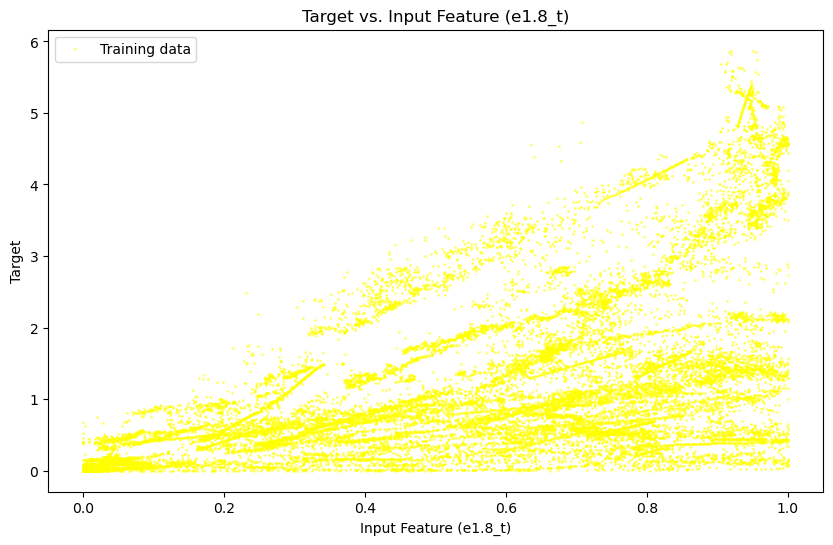

In [13]:
inputs_to_use = ['e1.8', 'e1.8', 'p']
input_to_return = 'e1.8_t'
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_univariate_dataset(root_dir + '/training',
                                            inputs_to_use=inputs_to_use,
                                            input_to_return=input_to_return,
                                            add_slope=add_slope,
                                            target_change=target_change)
X_subtrain, y_subtrain = build_univariate_dataset(root_dir + '/subtraining',
                                                  inputs_to_use=inputs_to_use,
                                                  input_to_return=input_to_return,
                                                  add_slope=add_slope,
                                                  target_change=target_change)
X_test, y_test = build_univariate_dataset(root_dir + '/testing',
                                          inputs_to_use=inputs_to_use,
                                          input_to_return=input_to_return,
                                          add_slope=add_slope,
                                          target_change=target_change)
X_val, y_val = build_univariate_dataset(root_dir + '/validation',
                                        inputs_to_use=inputs_to_use,
                                        input_to_return=input_to_return,
                                        add_slope=add_slope,
                                        target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

# Since X_train, and other datasets, are in the shape (n_samples, 1), we need to flatten them to (n_samples,)
X_train_flat = X_train.flatten()

# Plotting the target vs input feature 'p_t'
plt.figure(figsize=(10, 6))
plt.scatter(X_train_flat, y_train, alpha=0.5, label='Training data', s=1, color='yellow')
plt.title('Target vs. Input Feature (e1.8_t)')
plt.xlabel('Input Feature (e1.8_t)')
plt.ylabel('Target')
plt.legend()
plt.show()

In [14]:
inputs_to_use = ['e0.5', 'e1.8', 'p']
add_slope = False
target_change = True
# set the root directory
root_dir = '../data/electron_cme_data_split'
# build the dataset
X_train, y_train = build_dataset(root_dir + '/training',
                                 inputs_to_use=inputs_to_use,
                                 add_slope=add_slope,
                                 target_change=target_change)
X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining',
                                       inputs_to_use=inputs_to_use,
                                       add_slope=add_slope,
                                       target_change=target_change)
X_test, y_test = build_dataset(root_dir + '/testing',
                               inputs_to_use=inputs_to_use,
                               add_slope=add_slope,
                               target_change=target_change)
X_val, y_val = build_dataset(root_dir + '/validation',
                             inputs_to_use=inputs_to_use,
                             add_slope=add_slope,
                             target_change=target_change)

# print all data shapes
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_subtrain.shape: {X_subtrain.shape}')
print(f'y_subtrain.shape: {y_subtrain.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')
print(f'X_val.shape: {X_val.shape}')
print(f'y_val.shape: {y_val.shape}')

# print a sample of the training data
print(f'X_train[0]: {X_train[0]}')
print(f'y_train[0]: {y_train[0]}')

(24217, 75, 1)
(24217,)
(18952, 75, 1)
(18952,)
(10357, 75, 1)
(10357,)
(5265, 75, 1)
(5265,)
X_train.shape: (24217, 75, 1)
y_train.shape: (24217,)
X_subtrain.shape: (18952, 75, 1)
y_subtrain.shape: (18952,)
X_test.shape: (10357, 75, 1)
y_test.shape: (10357,)
X_val.shape: (5265, 75, 1)
y_val.shape: (5265,)
X_train[0]: [[0.83291813]
 [0.83244193]
 [0.83128651]
 [0.83031191]
 [0.82795357]
 [0.82972685]
 [0.82913708]
 [0.82226368]
 [0.81980303]
 [0.81911433]
 [0.81761693]
 [0.81884725]
 [0.81879556]
 [0.81841966]
 [0.81626247]
 [0.81702354]
 [0.81599169]
 [0.81549917]
 [0.81538844]
 [0.81522678]
 [0.81357089]
 [0.81149916]
 [0.81334833]
 [0.81401486]
 [0.81195032]
 [0.48465527]
 [0.4788582 ]
 [0.4788582 ]
 [0.47614084]
 [0.47311252]
 [0.47398247]
 [0.47180709]
 [0.45771414]
 [0.44302786]
 [0.44819982]
 [0.45129612]
 [0.4395381 ]
 [0.45298753]
 [0.44381562]
 [0.44287087]
 [0.44223638]
 [0.44144699]
 [0.44001532]
 [0.43358671]
 [0.43114536]
 [0.44413254]
 [0.43163419]
 [0.43260982]
 [0.4361

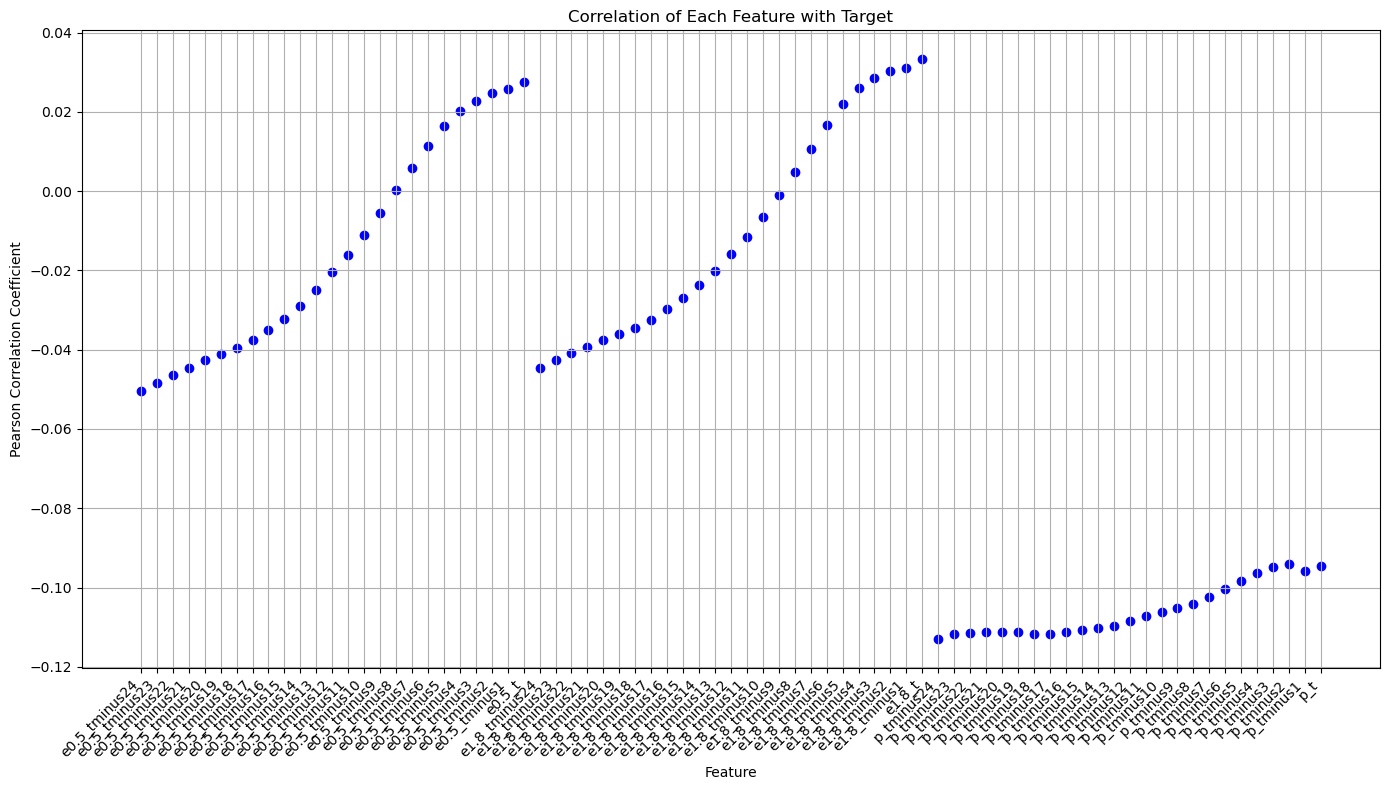

In [18]:
# Assuming X_train is shaped (24217, 75, 1) and y_train is (24217,)
# Reshape X_train to (24217, 75) for easier processing
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1])

# Initialize a list to hold correlation coefficients
correlations = []

# Calculate the Pearson correlation coefficient for each feature
for i in range(X_train_reshaped.shape[1]):
    corr, _ = pearsonr(X_train_reshaped[:, i], y_train)
    correlations.append(corr)
    
feature_names = generate_feature_names(inputs_to_use, add_slope)

# Plotting as a scatter plot
plt.figure(figsize=(14, 8))  # Adjusted figure size for better legibility
plt.scatter(range(len(correlations)), correlations, color='b')  # Use scatter instead of plot

# Adding feature names on the x-axis
plt.xticks(range(len(feature_names)), feature_names, rotation=45, ha="right")  # Rotate labels to prevent overlap

plt.title('Correlation of Each Feature with Target')
plt.xlabel('Feature')
plt.ylabel('Pearson Correlation Coefficient')
plt.grid(True)

# Tight layout often solves cutting off issues
plt.tight_layout()
plt.show()

In [ ]:
for inputs_to_use in [['e0.5', 'e1.8'], ['e0.5', 'e1.8', 'p'], ['e0.5'], ['e0.5', 'p']]:
    for add_slope in [True, False]:
        # PARAMS
        # inputs_to_use = ['e0.5']
        # add_slope = True

        # Join the inputs_to_use list into a string, replace '.' with '_', and join with '-'
        inputs_str = "_".join(input_type.replace('.', '_') for input_type in inputs_to_use)

        # Construct the title
        title = f'MLP_{inputs_str}_add_slope_{str(add_slope)}'

        # Replace any other characters that are not suitable for filenames (if any)
        title = title.replace(' ', '_').replace(':', '_')

        # Create a unique experiment name with a timestamp
        current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
        experiment_name = f'{title}_{current_time}'

        # Initialize wandb
        wandb.init(project="mlp-ts-pds", name=experiment_name, config={
            "inputs_to_use": inputs_to_use,
            "add_slope": add_slope,
        })

        # set the root directory
        root_dir = 'D:/College/Fall2023/electron_cme_v4/electron_cme_data_split'
        # build the dataset
        X_train, y_train = build_dataset(root_dir + '/training', inputs_to_use=inputs_to_use, add_slope=add_slope)
        X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining', inputs_to_use=inputs_to_use,
                                               add_slope=add_slope)
        X_test, y_test = build_dataset(root_dir + '/testing', inputs_to_use=inputs_to_use, add_slope=add_slope)
        X_val, y_val = build_dataset(root_dir + '/validation', inputs_to_use=inputs_to_use, add_slope=add_slope)

        # print all data shapes
        print(f'X_train.shape: {X_train.shape}')
        print(f'y_train.shape: {y_train.shape}')
        print(f'X_subtrain.shape: {X_subtrain.shape}')
        print(f'y_subtrain.shape: {y_subtrain.shape}')
        print(f'X_test.shape: {X_test.shape}')
        print(f'y_test.shape: {y_test.shape}')
        print(f'X_val.shape: {X_val.shape}')
        print(f'y_val.shape: {y_val.shape}')

        # print a sample of the training data
        print(f'X_train[0]: {X_train[0]}')
        print(f'y_train[0]: {y_train[0]}')

        # get the number of features
        n_features = X_train.shape[1]
        print(f'n_features: {n_features}')
        hiddens = [100, 100, 50]

        # create the model
        # mlp_model_sep = create_mlp(input_dim=n_features, hiddens=hiddens)
        mlp_model_sep = mb.create_model_pds(input_dim=n_features, hiddens=hiddens, feat_dim=9)
        mlp_model_sep.summary()

        # Set the early stopping patience and learning rate as variables
        Options = {
            'batch_size': 32,  # Assuming batch_size is defined elsewhere
            'epochs': 10000,
            'patience': 50,  # Updated to 50
            'learning_rate': 3e-4,  # Updated to 3e-4
            'weight_decay': 0,  # Added weight decay
            'momentum_beta1': 0.9,  # Added momentum beta1
        }

        # Define the EarlyStopping callback
        # early_stopping = EarlyStopping(monitor='val_forecast_head_loss', patience=patience, verbose=1,
        #                                restore_best_weights=True)

        # Compile the model with the specified learning rate
        # mlp_model_sep.compile(optimizer=Adam(learning_rate=learning_rate,
        #                                       weight_decay=weight_decay,
        #                                       beta_1=momentum_beta1),
        #                       loss={'forecast_head': 'mse'})

        # Train the model with the callback
        # history = mlp_model_sep.fit(X_subtrain,
        #                             {'forecast_head': y_subtrain},
        #                             epochs=1000, batch_size=32,
        #                             validation_data=(X_val, {'forecast_head': y_val}),
        #                             callbacks=[early_stopping, WandbCallback()])

        # Plot the training and validation loss
        # plt.figure(figsize=(12, 6))
        # plt.plot(history.history['loss'], label='Training Loss')
        # plt.plot(history.history['val_loss'], label='Validation Loss')
        # plt.title('Training and Validation Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.legend()
        # # save the plot
        # plt.savefig(f'mlp_loss_{title}.png')

        # Determine the optimal number of epochs from early stopping
        # optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset
        # final_mlp_model_sep = create_mlp(input_dim=n_features,
        #                                  hiddens=hiddens)  # Recreate the model architecture
        # final_mlp_model_sep.compile(optimizer=Adam(learning_rate=learning_rate,
        #                                             weight_decay=weight_decay,
        #                                             beta_1=momentum_beta1),
        #                             loss={'forecast_head': 'mse'})  # Compile the model just like before
        # # Train on the full dataset
        # final_mlp_model_sep.fit(X_train, {'forecast_head': y_train}, epochs=optimal_epochs, batch_size=32,
        #                         verbose=1)

        # evaluate the model on test data
        # error_mae = evaluate_model(final_mlp_model_sep, X_test, y_test)
        # print(f'mae error: {error_mae}')
        # # Log the MAE error to wandb
        # wandb.log({"mae_error": error_mae})

        # Process SEP event files in the specified directory
        # test_directory = root_dir + '/testing'
        # filenames = process_sep_events(
        #     test_directory,
        #     final_mlp_model_sep,
        #     model_type='mlp',
        #     title=title,
        #     inputs_to_use=inputs_to_use,
        #     add_slope=add_slope)

        # Log the plot to wandb
        # for filename in filenames:
        #     wandb.log({f'{filename}': wandb.Image(filename)})

        mb.train_pds(mlp_model_sep,
                     X_subtrain, y_subtrain,
                     X_val, y_val,
                     X_train, y_train,
                     learning_rate=Options['learning_rate'],
                     epochs=Options['epochs'],
                     batch_size=Options['batch_size'],
                     patience=Options['patience'], save_tag=current_time + "_features")

        # Log model to Weights & Biases
        wandb.log_artifact('path/to/model', type='model', name='pds_model')

        file_path = plot_tsne_pds(mlp_model_sep,
                                  X_train,
                                  y_train,
                                  title, 'training',
                                  save_tag=current_time)

        # Log t-SNE plot for training
        wandb.log_artifact(file_path, type='plot', name='tsne_training_plot')
        print('file_path: ' + file_path)

        file_path = plot_tsne_pds(mlp_model_sep,
                                  X_test,
                                  y_test,
                                  title, 'testing',
                                  save_tag=current_time)

        # Log t-SNE plot for testing
        wandb.log_artifact(file_path, type='plot', name='tsne_testing_plot')
        print('file_path: ' + file_path)

        # Finish the wandb run
        wandb.finish()




In [ ]:
for inputs_to_use in [['e0.5', 'e1.8'], ['e0.5', 'e1.8', 'p']]:
    for add_slope in [True, False]:
        for cme_speed_threshold in [0, 500]:
            # PARAMS
            # inputs_to_use = ['e0.5']
            # add_slope = True

            # Join the inputs_to_use list into a string, replace '.' with '_', and join with '-'
            inputs_str = "_".join(input_type.replace('.', '_') for input_type in inputs_to_use)

            # Construct the title
            title = f'MLP_{inputs_str}_add_slope_{str(add_slope)}'

            # Replace any other characters that are not suitable for filenames (if any)
            title = title.replace(' ', '_').replace(':', '_')

            # Create a unique experiment name with a timestamp
            current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
            experiment_name = f'{title}_{current_time}'

            # Initialize wandb
            wandb.init(project="mlp-ts-lowerlr", name=experiment_name, config={
                "inputs_to_use": inputs_to_use,
                "add_slope": add_slope,
            })

            # set the root directory
            root_dir = 'D:/College/Fall2023/electron_cme_v4/electron_cme_data_split'
            # build the dataset
            X_train, y_train = build_dataset(root_dir + '/training', inputs_to_use=inputs_to_use, add_slope=add_slope)
            X_subtrain, y_subtrain = build_dataset(root_dir + '/subtraining', inputs_to_use=inputs_to_use,
                                                   add_slope=add_slope)
            X_test, y_test = build_dataset(root_dir + '/testing', inputs_to_use=inputs_to_use, add_slope=add_slope)
            X_val, y_val = build_dataset(root_dir + '/validation', inputs_to_use=inputs_to_use, add_slope=add_slope)

            # print all data shapes
            print(f'X_train.shape: {X_train.shape}')
            print(f'y_train.shape: {y_train.shape}')
            print(f'X_subtrain.shape: {X_subtrain.shape}')
            print(f'y_subtrain.shape: {y_subtrain.shape}')
            print(f'X_test.shape: {X_test.shape}')
            print(f'y_test.shape: {y_test.shape}')
            print(f'X_val.shape: {X_val.shape}')
            print(f'y_val.shape: {y_val.shape}')

            # print a sample of the training data
            print(f'X_train[0]: {X_train[0]}')
            print(f'y_train[0]: {y_train[0]}')

            # get the number of features
            n_features = X_train.shape[1]
            print(f'n_features: {n_features}')
            hiddens = [100, 100, 50]

            # create the model
            # mlp_model_sep = create_mlp(input_dim=n_features, hiddens=hiddens)
            mlp_model_sep = modeling.create_mlp(input_dim=n_features, hiddens=hiddens)
            mlp_model_sep.summary()

            # Set the early stopping patience and learning rate as variables
            patience = 50
            learning_rate = 3e-5
            weight_decay = 0  # higher weight decay
            momentum_beta1 = 0.9  # higher momentum beta1

            # Define the EarlyStopping callback
            early_stopping = EarlyStopping(monitor='val_forecast_head_loss', patience=patience, verbose=1,
                                           restore_best_weights=True)

            # Compile the model with the specified learning rate
            mlp_model_sep.compile(optimizer=Adam(learning_rate=learning_rate,
                                                 weight_decay=weight_decay,
                                                 beta_1=momentum_beta1),
                                  loss={'forecast_head': 'mse'})

            # Train the model with the callback
            history = mlp_model_sep.fit(X_subtrain,
                                        {'forecast_head': y_subtrain},
                                        epochs=1000, batch_size=32,
                                        validation_data=(X_val, {'forecast_head': y_val}),
                                        callbacks=[early_stopping, WandbCallback()])

            # Plot the training and validation loss
            plt.figure(figsize=(12, 6))
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            # save the plot
            plt.savefig(f'mlp_loss_{title}.png')

            # Determine the optimal number of epochs from early stopping
            optimal_epochs = early_stopping.stopped_epoch - patience + 1  # Adjust for the offset
            final_mlp_model_sep = create_mlp(input_dim=n_features,
                                             hiddens=hiddens)  # Recreate the model architecture
            final_mlp_model_sep.compile(optimizer=Adam(learning_rate=learning_rate,
                                                       weight_decay=weight_decay,
                                                       beta_1=momentum_beta1),
                                        loss={'forecast_head': 'mse'})  # Compile the model just like before
            # Train on the full dataset
            final_mlp_model_sep.fit(X_train, {'forecast_head': y_train}, epochs=optimal_epochs, batch_size=32,
                                    verbose=1)

            # evaluate the model on test data
            error_mae = evaluate_model(final_mlp_model_sep, X_test, y_test)
            print(f'mae error: {error_mae}')
            # Log the MAE error to wandb
            wandb.log({"mae_error": error_mae})

            # Process SEP event files in the specified directory
            test_directory = root_dir + '/testing'
            filenames = process_sep_events(
                test_directory,
                final_mlp_model_sep,
                model_type='mlp',
                title=title,
                inputs_to_use=inputs_to_use,
                add_slope=add_slope)

            # Log the plot to wandb
            for filename in filenames:
                wandb.log({f'{filename}': wandb.Image(filename)})

            # Finish the wandb run
            wandb.finish()
    
    
